In [5]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import numpy as np

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
import warnings
warnings.filterwarnings("ignore")

In [6]:
# check current running python version
import sys
print(sys.version)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [7]:
import sys
import logging
import datetime

nblog = open("./logs/catboost_pdp_shap_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [8]:
%%time
df_localness = pd.read_csv('./data/food_localness_final_oct.csv')
print('unique orders:',df_localness.shape[0])
print('unique accounts:',df_localness.account_id.unique().shape[0])
df_localness.head(2)

unique orders: 2887183
unique accounts: 573316
CPU times: user 33.5 s, sys: 9.39 s, total: 42.9 s
Wall time: 1min 26s


,account_id,order_id,order_date,order_time,vendor_id,vendor_name,main_cuisine,vertical,delivery_fee_amount_lc,service_fee_amount_lc,basket_amount_lc,is_incentive_applied,incentive_amount_lc,pickup_id,customer_lon,customer_lat,vendor_lon,vendor_lat,order_time_hour,delivery_duration,total_duration,customer_geometry,vendor_geometry,order_distance_km,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,nearest_euc_distance,localness,customer_loc_id,entropy_3.6km,item_price,compensation,discounted delivery,free delivery,gem,item discount,menu discount,voucher wallet,appoxi_rent,entropy_2km,entropy_0.3km,isweekend,poi_count_1km,poi_count_2km,poi_count_3km,poi_count_4km,poi_count_5km,incentives_type,poi_count_1_2km,poi_count_2_3km,poi_count_3_4km,poi_count_4_5km,rating,n_rating,incentive_delivery,incentive_menu_discount,incentive_voucher_wallet,consistency,total_orders
0,4285647,1305786978,2023-10-10,2023-10-10 18:37:22,15921,"312 , Al Sufouh 1",american,food,9.0,2.36,78.5,0,0.0,249215302.0,55.22939,25.164577,55.175844,25.107854,18,37,54,POINT (6148107.571623116 2895972.7784882844),POINT (6142146.858169098 2888997.883505384),9.174926,food,702934,american,"My Hot Dog, Jumeirah 3",55.221344,25.176179,1.684822,0.183633,55.2293925.164577,0.670995,26.679487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.209394,0.625864,0.000000,False,8.0,96.0,243.0,352.0,570.0,none,88.0,147.0,109.0,218.0,Very good,Amazing,False,False,False,0.873791,25
1,1349127,1305612765,2023-10-10,2023-10-10 16:02:54,702587,"Subz, Business Bay",american,food,5.0,2.34,78.0,True,30.0,249170878.0,55.27096,25.180780,55.269598,25.188222,16,10,32,POINT (6152735.122855392 2897965.761873224),POINT (6152583.494576982 2898881.161766449),0.927873,food,702037,american,"Burger Basics, Business Bay",55.275506,25.180872,0.506177,0.545524,55.2709625.18078,0.744623,37.650000,0.0,0.0,0.0,0.0,0.0,30.0,0.0,95.263292,0.753064,0.414145,False,247.0,491.0,798.0,1064.0,1297.0,menu discount,244.0,307.0,266.0,233.0,Very good,Very good,False,True,False,0.878495,15


# Left join with rating data

In [ ]:
# df_ratings = pd.read_csv('./data/restaurant_ratings.csv')
# df_ratings = df_ratings[['vendor_id','rating']]
# print(df_ratings.shape[0])
# print(df_ratings.rating.value_counts())
# df_ratings.head()

In [25]:
# # left join with the picked resturants
# df_localness_rating = df_localness.merge(df_ratings, how='left')
# print(df_localness_rating.shape[0])
# df_localness_rating['rating'] = df_localness_rating['rating'].fillna('None')
# print(df_localness_rating.shape[0])

2887183


,account_id,order_id,order_date,order_time,vendor_id,vendor_name,main_cuisine,vertical,delivery_fee_amount_lc,service_fee_amount_lc,basket_amount_lc,is_incentive_applied,incentive_amount_lc,pickup_id,customer_lon,customer_lat,vendor_lon,vendor_lat,order_time_hour,delivery_duration,total_duration,customer_geometry,vendor_geometry,order_distance_km,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,nearest_euc_distance,localness,customer_loc_id,entropy_3.6km,item_price,compensation,discounted delivery,free delivery,gem,item discount,menu discount,voucher wallet,appoxi_rent,entropy_2km,entropy_0.3km,isweekend,poi_count_1km,poi_count_2km,poi_count_3km,poi_count_4km,poi_count_5km,incentives_type,poi_count_1_2km,poi_count_2_3km,poi_count_3_4km,poi_count_4_5km,rating
0,4285647,1305786978,2023-10-10,2023-10-10 18:37:22,15921,"312 , Al Sufouh 1",american,food,9.0,2.36,78.5,0,0.0,249215302.0,55.22939,25.164577,55.175844,25.107854,18,37,54,POINT (6148107.571623116 2895972.7784882844),POINT (6142146.858169098 2888997.883505384),9.174926,food,702934,american,"My Hot Dog, Jumeirah 3",55.221344,25.176179,1.684822,0.183633,55.2293925.164577,0.670995,26.679487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.209394,0.625864,0.000000,False,8.0,96.0,243.0,352.0,570.0,none,88.0,147.0,109.0,218.0,Very good
1,1349127,1305612765,2023-10-10,2023-10-10 16:02:54,702587,"Subz, Business Bay",american,food,5.0,2.34,78.0,True,30.0,249170878.0,55.27096,25.180780,55.269598,25.188222,16,10,32,POINT (6152735.122855392 2897965.761873224),POINT (6152583.494576982 2898881.161766449),0.927873,food,702037,american,"Burger Basics, Business Bay",55.275506,25.180872,0.506177,0.545524,55.2709625.18078,0.744623,37.650000,0.0,0.0,0.0,0.0,0.0,30.0,0.0,95.263292,0.753064,0.414145,False,247.0,491.0,798.0,1064.0,1297.0,menu discount,244.0,307.0,266.0,233.0,Very good


In [34]:
# # left join with nearest restaurants
# df_ratings = df_ratings.rename(columns={"vendor_id": "n_vendor_id", "rating":"n_rating"})
# df_localness_rating = df_localness_rating.merge(df_ratings, how='left')
# df_localness_rating['n_rating'] = df_localness_rating['n_rating'].fillna('None')
# print(df_localness_rating.shape[0])

2887183


create some dummy var for three important incentive types

In [40]:
# df_localness_rating['incentive_delivery'] = 'False'
# df_localness_rating.loc[df_localness_rating['discounted delivery'] != 0,'incentive_delivery'] = 'True'
# df_localness_rating.loc[df_localness_rating['free delivery'] != 0,'incentive_delivery'] = 'True'

# df_localness_rating['incentive_menu_discount'] = 'False'
# df_localness_rating.loc[df_localness_rating['menu discount'] != 0,'incentive_menu_discount'] = 'True'

# df_localness_rating['incentive_voucher_wallet'] = 'False'
# df_localness_rating.loc[df_localness_rating['voucher wallet'] != 0,'incentive_voucher_wallet'] = 'True'

# # df_localness_rating['incentive_delivery'] = 'False'
# # df_localness_rating.loc[df_localness_rating['discounted delivery'] != 0,'incentive_delivery'] = 'True'
# # df_localness_rating.loc[df_localness_rating['free delivery'] != 0,'incentive_delivery'] = 'True'

# Individual order consistency indicator: entropy
Lower value of entropy means high consistency

In [78]:
# def compute_entropy_function(x):
#     x = x.reset_index()
#     total_cuisines = x.main_cuisine.unique().shape[0]
#     if total_cuisines == 1:
#         return 0
#     sum_nominator = 0
#     for prop in x['consistency'].tolist(): # each element is a proportion of one cuisine
#         sum_nominator += prop*(np.log(1/prop))
#     entropy = sum_nominator/np.log(total_cuisines)
#     return entropy

In [47]:
# %%time
# df_localness_rating['consistency'] = 1
# groupped_data = df_localness_rating.groupby(['account_id','main_cuisine']).agg({'consistency': 'sum'})
# # df_localness_rating.groupby('account_id').apply(compute_entropy_function).reset_index() #compute entropy

CPU times: user 2.99 ms, sys: 0 ns, total: 2.99 ms
Wall time: 2.76 ms


In [56]:
# %%time
# print(groupped_data.shape[0])
# groupped_data = groupped_data.groupby(level=0).apply(lambda x:  x / x.sum()) # convert to proportions # check id = 1008

1455325
CPU times: user 6min 31s, sys: 2.94 s, total: 6min 34s
Wall time: 9min 9s


In [79]:
# %%time
# groupped_data_entropy = groupped_data.groupby('account_id').apply(compute_entropy_function).reset_index() # compute entropy

CPU times: user 7min 12s, sys: 435 ms, total: 7min 13s
Wall time: 10min


<AxesSubplot:>

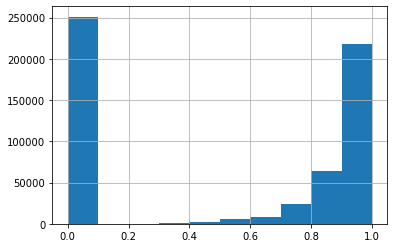

In [83]:
# groupped_data_entropy.columns = ['account_id', 'consistency']
# groupped_data_entropy.consistency.hist()
# Two peaks: either very consistent (0) or very inconsistent (1)

In [84]:
# df_localness_rating = df_localness_rating.drop(['consistency'], axis=1)
# df_localness_rating = df_localness_rating.merge(groupped_data_entropy, how='left')
# print(df_localness_rating['consistency'].isnull().values.any())
# print(df_localness_rating.shape[0])

False
2887183


# Total number of orders in one month for each individual
entropy of consistency itself may be biased so also incorporate total number of orders each person placed in Oct

In [88]:
# df_totalorders = df_localness_rating[['account_id','vendor_id']].groupby('account_id').count().reset_index()
# df_totalorders.columns = ['account_id', 'total_orders']
# # df_totalorders.head()
# df_localness_rating = df_localness_rating.merge(df_totalorders, how='left')
# print(df_localness_rating['total_orders'].isnull().values.any())
# print(df_localness_rating.shape[0])

,account_id,total_orders
0,1008,2
1,4626,19
2,7546,1
3,11584,2
4,14949,25


In [91]:
# df_localness_rating.to_csv('./data/food_localness_final_oct.csv',index=False)

# Feature engineering

In [9]:
df_localness.head(2)

,account_id,order_id,order_date,order_time,vendor_id,vendor_name,main_cuisine,vertical,delivery_fee_amount_lc,service_fee_amount_lc,basket_amount_lc,is_incentive_applied,incentive_amount_lc,pickup_id,customer_lon,customer_lat,vendor_lon,vendor_lat,order_time_hour,delivery_duration,total_duration,customer_geometry,vendor_geometry,order_distance_km,n_vertical,n_vendor_id,n_main_cuisine,n_vendor_name,n_vendor_lon,n_vendor_lat,nearest_euc_distance,localness,customer_loc_id,entropy_3.6km,item_price,compensation,discounted delivery,free delivery,gem,item discount,menu discount,voucher wallet,appoxi_rent,entropy_2km,entropy_0.3km,isweekend,poi_count_1km,poi_count_2km,poi_count_3km,poi_count_4km,poi_count_5km,incentives_type,poi_count_1_2km,poi_count_2_3km,poi_count_3_4km,poi_count_4_5km,rating,n_rating,incentive_delivery,incentive_menu_discount,incentive_voucher_wallet,consistency,total_orders
0,4285647,1305786978,2023-10-10,2023-10-10 18:37:22,15921,"312 , Al Sufouh 1",american,food,9.0,2.36,78.5,0,0.0,249215302.0,55.22939,25.164577,55.175844,25.107854,18,37,54,POINT (6148107.571623116 2895972.7784882844),POINT (6142146.858169098 2888997.883505384),9.174926,food,702934,american,"My Hot Dog, Jumeirah 3",55.221344,25.176179,1.684822,0.183633,55.2293925.164577,0.670995,26.679487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.209394,0.625864,0.000000,False,8.0,96.0,243.0,352.0,570.0,none,88.0,147.0,109.0,218.0,Very good,Amazing,False,False,False,0.873791,25
1,1349127,1305612765,2023-10-10,2023-10-10 16:02:54,702587,"Subz, Business Bay",american,food,5.0,2.34,78.0,True,30.0,249170878.0,55.27096,25.180780,55.269598,25.188222,16,10,32,POINT (6152735.122855392 2897965.761873224),POINT (6152583.494576982 2898881.161766449),0.927873,food,702037,american,"Burger Basics, Business Bay",55.275506,25.180872,0.506177,0.545524,55.2709625.18078,0.744623,37.650000,0.0,0.0,0.0,0.0,0.0,30.0,0.0,95.263292,0.753064,0.414145,False,247.0,491.0,798.0,1064.0,1297.0,menu discount,244.0,307.0,266.0,233.0,Very good,Very good,False,True,False,0.878495,15


In [10]:
%%time
df_features = df_localness[['basket_amount_lc','item_price','order_time_hour','total_duration',
                            'appoxi_rent', 'entropy_3.6km','entropy_2km','entropy_0.3km',
                            'incentive_amount_lc','incentive_delivery','incentive_menu_discount', 'incentive_voucher_wallet',
                             'isweekend', 'consistency','main_cuisine', 'total_orders', 'rating','n_rating',
                            'poi_count_1km','poi_count_1_2km','poi_count_2_3km','poi_count_3_4km','poi_count_4_5km']]

X = df_features
y = df_localness.localness

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# X_train.dtypes

import catboost as cb

train_dataset = cb.Pool(X_train, y_train, cat_features=['isweekend','main_cuisine','incentive_delivery','incentive_menu_discount',
                                                        'incentive_voucher_wallet','rating','n_rating'])
test_dataset = cb.Pool(X_test, y_test, cat_features=['isweekend','main_cuisine','incentive_delivery','incentive_menu_discount',
                                                     'incentive_voucher_wallet','rating','n_rating'])

CPU times: user 32.3 s, sys: 2.76 s, total: 35.1 s
Wall time: 50.2 s


# Training

In [8]:
%%time
# ~takes 9min
print(datetime.datetime.now(),'*************** Start running CatBoostRegressor ***************')

regressor = cb.CatBoostRegressor(custom_metric= ['R2', 'RMSE'], early_stopping_rounds=100)
regressor.fit(train_dataset, eval_set = test_dataset)
regressor.save_model('current_catboost_' + str(datetime.datetime.now()))

print(datetime.datetime.now(),'*************** Done running CatBoostRegressor ***************')

2024-05-31 11:58:50.801847 *************** Start running CatBoostRegressor ***************
Learning rate set to 0.168217
0:	learn: 0.2906112	test: 0.2906731	best: 0.2906731 (0)	total: 874ms	remaining: 14m 33s
1:	learn: 0.2821494	test: 0.2822328	best: 0.2822328 (1)	total: 1.47s	remaining: 12m 11s
2:	learn: 0.2757089	test: 0.2758091	best: 0.2758091 (2)	total: 2.02s	remaining: 11m 11s
3:	learn: 0.2708377	test: 0.2709428	best: 0.2709428 (3)	total: 2.58s	remaining: 10m 41s
4:	learn: 0.2670856	test: 0.2672106	best: 0.2672106 (4)	total: 3.06s	remaining: 10m 9s
5:	learn: 0.2641214	test: 0.2642613	best: 0.2642613 (5)	total: 3.56s	remaining: 9m 50s
6:	learn: 0.2618964	test: 0.2620123	best: 0.2620123 (6)	total: 3.92s	remaining: 9m 15s
7:	learn: 0.2601908	test: 0.2603206	best: 0.2603206 (7)	total: 4.4s	remaining: 9m 5s
8:	learn: 0.2587217	test: 0.2588704	best: 0.2588704 (8)	total: 5.03s	remaining: 9m 13s
9:	learn: 0.2575234	test: 0.2576843	best: 0.2576843 (9)	total: 5.57s	remaining: 9m 11s
10:	lea

In [14]:
regressor = cb.CatBoostRegressor()
regressor.load_model("current_catboost_2024-05-31 12:11:47.674066")

# Evaluation

In [15]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Best Model RMSE: %.3f' % rmse)

r2 = r2_score(y_test, y_pred)
print('Best Model R-squared: %.3f' % r2)
# RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred) )
# Best Model RMSE: ~0.214
# Best Model R-squared: ~0.498

Best Model RMSE: 0.214
Best Model R-squared: 0.498
CPU times: user 12.5 s, sys: 1.08 s, total: 13.6 s
Wall time: 14.7 s


# Feature importance

2024-05-31 11:48:15.963391 *************** Done running feature importance ***************
CPU times: user 20.5 s, sys: 144 ms, total: 20.7 s
Wall time: 26.2 s


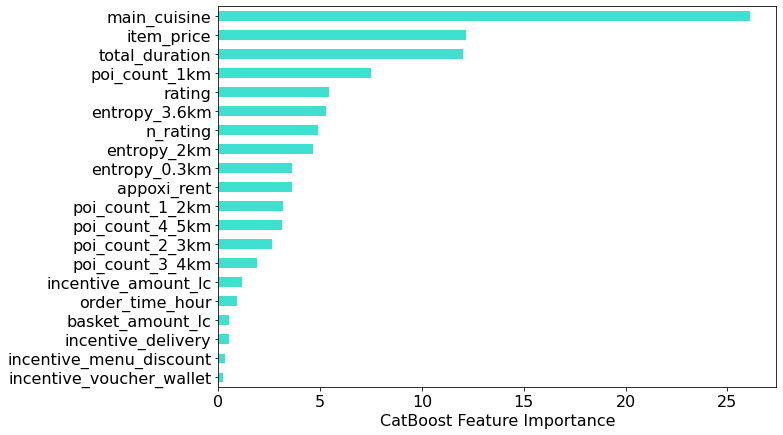

In [101]:
%%time

import matplotlib.pylab as plt
from matplotlib import pyplot

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1,figsize=(10,7))

df_feature_importance = pd.DataFrame({'feature_importance': regressor.get_feature_importance(train_dataset), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

df_feature_importance[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(
    x='feature_names', y='feature_importance',color='turquoise',ax=ax)

plt.xlabel("CatBoost Feature Importance")
ax.get_legend().remove()
ax.set(ylabel=None)
plt.savefig('./output/feature_importance.pdf',bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running feature importance ***************')

# PDP

In [16]:
feature_list_continuous= ['basket_amount_lc','item_price','order_time_hour','total_duration',
                          'appoxi_rent', 'entropy_3.6km','entropy_2km','entropy_0.3km','consistency', 'total_orders',
                          'incentive_amount_lc','poi_count_1km','poi_count_1_2km','poi_count_2_3km','poi_count_3_4km','poi_count_4_5km']
                          
print('number of continuous features:',len(feature_list_continuous))
feature_list_cat = ['isweekend','incentive_delivery', 'incentive_menu_discount', 'incentive_voucher_wallet', 'rating','n_rating']

number of continuous features: 16


## 1. PDP for continous features

In [ ]:
# %%time 
# I tried to plot all PDP all at once but seems to trigger memory errors
# print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

# plt.rcParams.update({'font.size': 14})
# fig, ax = plt.subplots(figsize=(12,15))
# plt.tight_layout()
# pdp_all_continuous = PartialDependenceDisplay.from_estimator(regressor, X, feature_list_continuous, n_jobs=8, ax=ax)
# plt.subplots_adjust(top=1.2)
# plt.savefig('./output/pdp_all_continuous.pdf', bbox_inches="tight")

# print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')
die

In [ ]:
%%time 
# ~ 14 min
# using for loop, otherwise might occur memory errors
# PDP for continuous features and save the graph for each feature separately
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_continuous ***************')

for feature_one in feature_list_continuous:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    pdp_one = PartialDependenceDisplay.from_estimator(regressor, X_train, [feature_one], ax=ax)
    plt.savefig('./output/pdp_' + feature_one + '.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_continuous ***************')

2024-05-31 15:11:36.597610 *************** Start running PDP: feature_list_continuous ***************
2024-05-31 15:11:36.597862 basket_amount_lc


## 2. PDP for categorical features 


2024-05-31 12:12:22.936577 *************** Start running PDP: feature_list_cat ***************
2024-05-31 12:12:22.936646 isweekend
2024-05-31 12:13:46.100084 incentive_delivery
2024-05-31 12:15:39.236948 incentive_menu_discount
2024-05-31 12:17:29.078164 incentive_voucher_wallet
2024-05-31 12:19:11.993130 rating
2024-05-31 12:22:47.419054 n_rating
2024-05-31 12:27:03.403559 *************** Done running PDP: feature_list_cat ***************
CPU times: user 5.32 s, sys: 5.13 s, total: 10.5 s
Wall time: 14min 40s


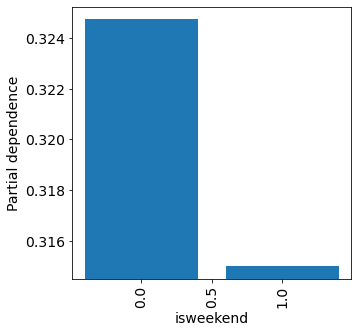

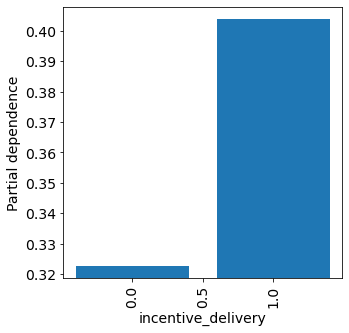

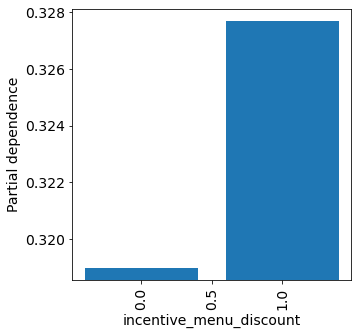

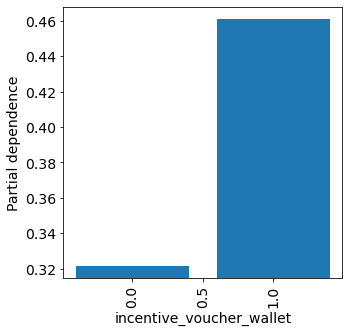

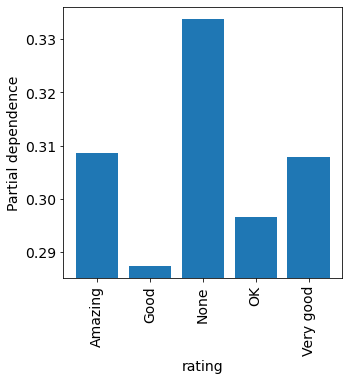

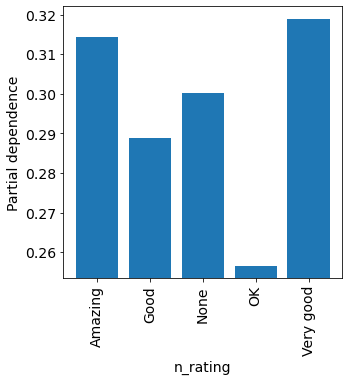

In [16]:
%%time 
print(datetime.datetime.now(),'*************** Start running PDP: feature_list_cat ***************')

for feature_one in feature_list_cat:
    print(datetime.datetime.now(), feature_one)
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(5,5))
    tree_disp_all = PartialDependenceDisplay.from_estimator(
        regressor, X, [feature_one], categorical_features=[feature_one], n_jobs=8 , ax=ax)
    plt.savefig('./output/pdp_'+feature_one+'.pdf',bbox_inches="tight")    

print(datetime.datetime.now(),'*************** Done running PDP: feature_list_cat ***************')

main_cusine is a huge categorical feature so create a customized graph

In [ ]:
%%time 
print(datetime.datetime.now(),'*************** Start running PDP: main_cusine ***************')

feature_select = 'main_cuisine'
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(18,6))
pdp_main_cusine = PartialDependenceDisplay.from_estimator(
    regressor, X, [feature_select], categorical_features=[feature_select],n_jobs=8 ,ax=ax)
plt.savefig('./output/pdp_'+feature_select+'.pdf', bbox_inches="tight")

print(datetime.datetime.now(),'*************** Done running PDP: main_cusine ***************')

2024-05-30 17:29:20.012650 *************** Start running PDP ***************


In [2]:
# print(pdp_main_cusine.bars_[0][0].get_height())
# print(pdp_main_cusine.bars_[0][0].get_x())

# SHAP

In [17]:
%%time
print(datetime.datetime.now(),'*************** Start running SHAP ***************')

import shap
explainer = shap.TreeExplainer(regressor)
shap_values = explainer(X)

print(datetime.datetime.now(),'*************** Done running SHAP ***************')

2024-05-31 13:36:21.866259 *************** Start running SHAP ***************
2024-05-31 13:42:15.433713 *************** Done running SHAP ***************
CPU times: user 10min 35s, sys: 25.4 s, total: 11min 1s
Wall time: 5min 53s


In [21]:
# shap_values.save('current_catboost_shap' + str(datetime.datetime.now()))

2024-05-31 13:45:50.643437 *************** Start running beeswarm ***************
2024-05-31 13:54:59.165633 *************** Done running beeswarm ***************
CPU times: user 5min 57s, sys: 2.8 s, total: 6min
Wall time: 9min 8s


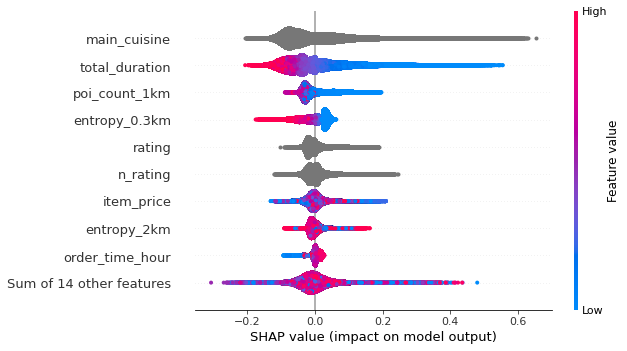

In [22]:
%%time
# ~6min
print(datetime.datetime.now(),'*************** Start running beeswarm ***************')
fig_beeswarm = shap.plots.beeswarm(shap_values,show=False)
plt.savefig('./output/shap_beeswarm.pdf', bbox_inches='tight')
print(datetime.datetime.now(),'*************** Done running beeswarm ***************')

CPU times: user 41.5 s, sys: 0 ns, total: 41.5 s
Wall time: 54.4 s


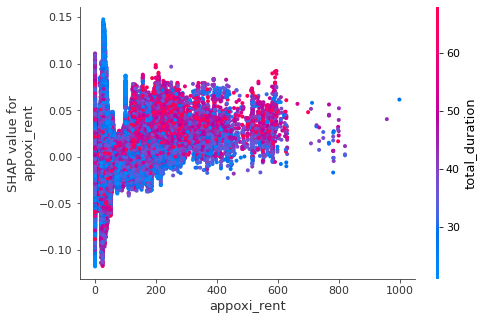

In [23]:
%%time
fig = shap.dependence_plot('appoxi_rent', shap_values.values, X, interaction_index='total_duration',show=False)
plt.savefig('./output/shap_appoxi_rent_total_duration.pdf',bbox_inches='tight')

CPU times: user 44.6 s, sys: 0 ns, total: 44.6 s
Wall time: 1min 2s


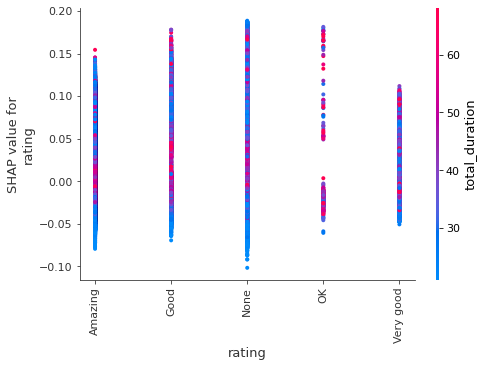

In [24]:
%%time
fig = shap.dependence_plot('rating', shap_values.values, X, interaction_index='total_duration',show=False)
plt.savefig('./output/shap_rating_total_duration.pdf',bbox_inches='tight')

CPU times: user 41.1 s, sys: 0 ns, total: 41.1 s
Wall time: 48.6 s


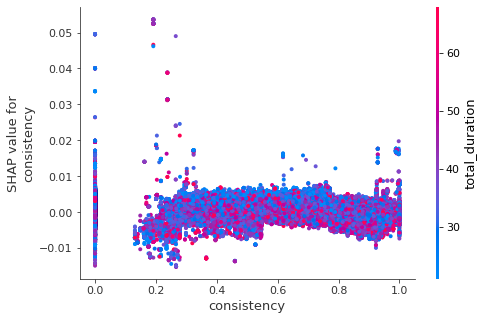

In [25]:
%%time
fig = shap.dependence_plot('consistency', shap_values.values, X, interaction_index='total_duration',show=False)
plt.savefig('./output/shap_consistency_total_duration.pdf',bbox_inches='tight')

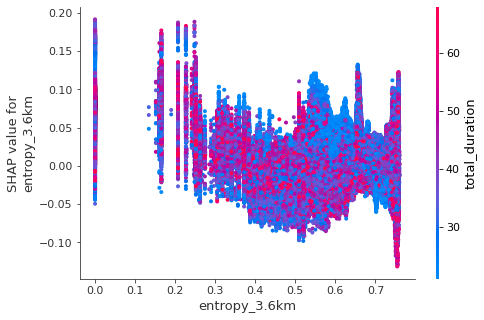

CPU times: user 15.5 s, sys: 1.09 s, total: 16.6 s
Wall time: 33.5 s


In [97]:
%%time
shap.dependence_plot('entropy_3.6km', shap_values.values, X, interaction_index='total_duration')

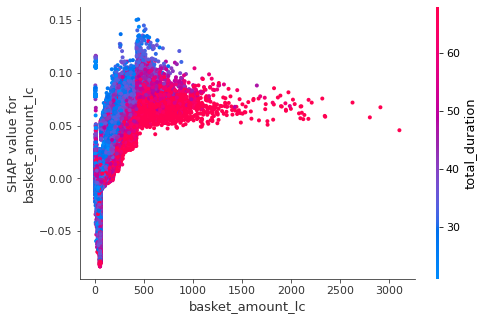

CPU times: user 16.8 s, sys: 754 ms, total: 17.6 s
Wall time: 30.9 s


In [84]:
%%time
shap.dependence_plot(0, shap_values.values, X)
# interaction_index“auto”, pick the strongest interaction
# basket amount has a bigger effect on shorter duration orders than on longer duration orders

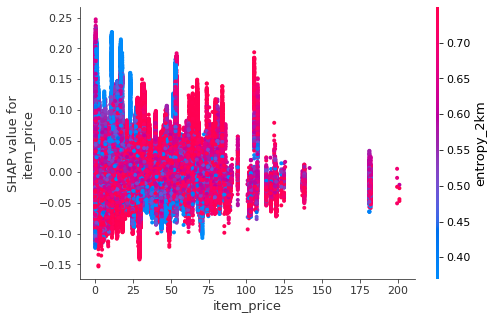

In [86]:
%%time
shap.dependence_plot(1, shap_values.values, X)

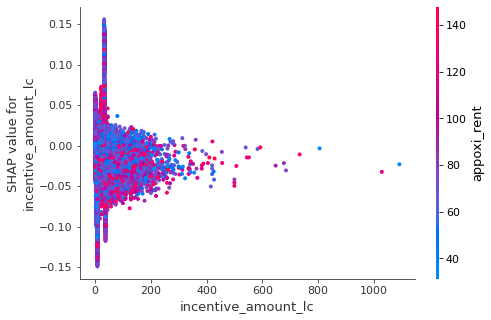

CPU times: user 15.3 s, sys: 1.22 s, total: 16.6 s
Wall time: 30.4 s


In [87]:
%%time
shap.dependence_plot('incentive_amount_lc', shap_values.values, X ,interaction_index='appoxi_rent')

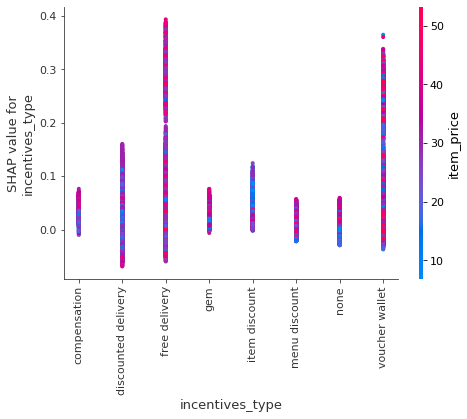

CPU times: user 18.4 s, sys: 1.3 s, total: 19.7 s
Wall time: 39.3 s


In [88]:
%%time
shap.dependence_plot('incentives_type', shap_values.values, X ,interaction_index='item_price')

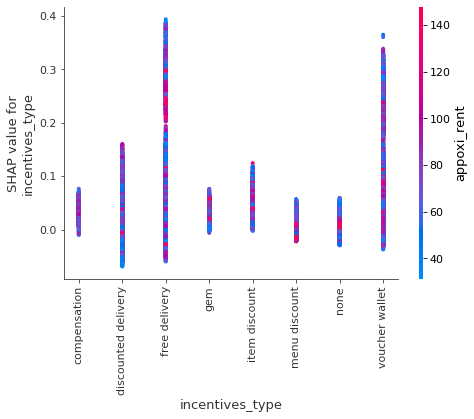

CPU times: user 19.5 s, sys: 1.2 s, total: 20.7 s
Wall time: 34 s


In [91]:
%%time
shap.dependence_plot('incentives_type', shap_values.values, X ,interaction_index='appoxi_rent')

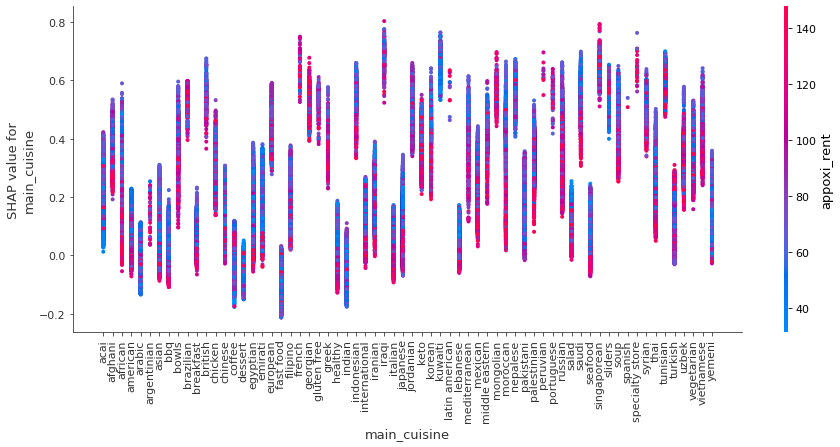

CPU times: user 21 s, sys: 1.02 s, total: 22.1 s
Wall time: 38.4 s


In [90]:
%%time
plt.rcParams.update({'font.size': 14})
fig_cuisine, ax_cuisine = plt.subplots(figsize=(18,6))
shap.dependence_plot('main_cuisine', shap_values.values, X, ax=ax_cuisine, interaction_index='appoxi_rent')